In [87]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, LocalOutlierFactor

In [48]:
# read in the data
data = pd.read_csv('../data/US_Accidents_March23_sampled_500k.csv')
data.shape

(500000, 46)

Let's see the variables in our data and decide which will we our target variable.

In [49]:
data.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

The target variable will be 'Severity', this is how important, the gravity of the accident, in order to predict how does it affect the traffic.

First we take off some variables which we consider may not explain the target.

In [50]:
data_w_c = data.drop(columns=['ID', 'Source', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Weather_Timestamp'])
data_w_c.shape

(500000, 35)

The Start_Time and End_Time variables cause some problems since they are strings and are difficult to compute. In order to avoid further problems we will create a new variable called Elapsed_Time, which will be the difference between End_Time and Start_Time.

In [84]:
data['Start_Time'].isna().sum()

0

In [85]:
data['End_Time'].isna().sum()

0

These two variables do not present any Nan, so we can proceed creating this new variable.

In [51]:
def time_difference(data_w_c: pd.DataFrame) -> list[int]:
    """Calculates the time difference between the start and end time of each accident in seconds."""
    time_elapsed: list[int] = list()
    for start_time, end_time in zip(data_w_c['Start_Time'], data_w_c['End_Time']):
        start_year = int(start_time[:4]) 
        end_year = int(end_time[:4])
        elapsed_years = end_year - start_year
        start_month = int(start_time[5:7])
        end_month = int(end_time[5:7])
        elapsed_months = end_month - start_month
        start_day = int(start_time[8:10])
        end_day = int(end_time[8:10])
        elapsed_days = end_day - start_day
        start_hour = int(start_time[11:13])
        end_hour = int(end_time[11:13])
        elapsed_hours = end_hour - start_hour
        start_minute = int(start_time[14:16])
        end_minute = int(end_time[14:16])
        elapsed_minutes = end_minute - start_minute
        start_second = int(start_time[17:19])
        end_second = int(end_time[17:19])
        elapsed_seconds = abs(end_second - start_second)
        time_elapsed.append(elapsed_years*31536000 + elapsed_months*2592000 + elapsed_days*86400 + elapsed_hours*3600 + elapsed_minutes*60 + elapsed_seconds)
    return time_elapsed

In [52]:
data_w_c['Time_Difference'] = pd.DataFrame(time_difference(data_w_c))
data_w_c.shape

(500000, 36)

Now that we have this information in this new variable, we can take off 'Start_Time' and 'End_Time'.

In [53]:
data_w_c = data_w_c.drop(columns=['Start_Time', 'End_Time'])
data_w_c.shape

(500000, 34)

SEARCHING NAN'S

Let's see the summary of our dataset now in order to Identify possibles Nan's.

In [54]:
data_w_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               500000 non-null  int64  
 1   Start_Lat              500000 non-null  float64
 2   Start_Lng              500000 non-null  float64
 3   End_Lat                279623 non-null  float64
 4   End_Lng                279623 non-null  float64
 5   Distance(mi)           500000 non-null  float64
 6   Airport_Code           498554 non-null  object 
 7   Temperature(F)         489534 non-null  float64
 8   Wind_Chill(F)          370983 non-null  float64
 9   Humidity(%)            488870 non-null  float64
 10  Pressure(in)           491072 non-null  float64
 11  Visibility(mi)         488709 non-null  float64
 12  Wind_Direction         488803 non-null  object 
 13  Wind_Speed(mph)        463013 non-null  float64
 14  Precipitation(in)      357384 non-nu

The target value severity is categorical and Python identifies it as an int, so lets correct this. Also for the bool variables, let's make them an object.

In [55]:
data_w_c.Severity = data_w_c.Severity.astype('object')
for column in ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']:
    data_w_c[column] = data_w_c[column].astype('object')

In [56]:
data_w_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               500000 non-null  object 
 1   Start_Lat              500000 non-null  float64
 2   Start_Lng              500000 non-null  float64
 3   End_Lat                279623 non-null  float64
 4   End_Lng                279623 non-null  float64
 5   Distance(mi)           500000 non-null  float64
 6   Airport_Code           498554 non-null  object 
 7   Temperature(F)         489534 non-null  float64
 8   Wind_Chill(F)          370983 non-null  float64
 9   Humidity(%)            488870 non-null  float64
 10  Pressure(in)           491072 non-null  float64
 11  Visibility(mi)         488709 non-null  float64
 12  Wind_Direction         488803 non-null  object 
 13  Wind_Speed(mph)        463013 non-null  float64
 14  Precipitation(in)      357384 non-nu

First we will compute the missing values for categorical variables and then for the continuous.

In [57]:
data_w_c.describe(include=['O'])

,Severity,Airport_Code,Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,500000,498554,488803,488899,500000,500000,500000,500000,500000,500000,...,500000,500000,500000,500000,500000,500000,498517,498517,498517,498517
unique,4,1878,24,108,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
top,2,KCQT,CALM,Fair,False,False,False,False,False,False,...,False,False,False,False,False,False,Day,Day,Day,Day
freq,398142,7756,62259,166053,493809,499789,443747,497638,462993,498755,...,499987,487002,485937,499534,425965,500000,344967,368274,392866,412242


It does not seem to be any missing value for the categorical values of the dataset, using the information available from the description. There are some Nan's, but these are detected by Python, so for the moment there is anything to worry about.

Now let's do the same for numerical variables.

In [58]:
data_w_c.describe(include=['int', 'float'])

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,500000.000000,500000.000000,279623.000000,279623.000000,500000.000000,489534.000000,370983.000000,488870.000000,491072.000000,488709.000000,463013.000000,357384.000000,5.000000e+05
mean,36.206421,-94.736583,36.273192,-95.776553,0.564317,61.646254,58.229028,64.834921,29.536621,9.091540,7.681347,0.008289,2.538400e+04
std,5.071411,17.405761,5.265333,18.120211,1.774872,19.000133,22.352246,22.826158,1.008666,2.708083,5.431361,0.101865,7.922189e+05
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,-77.800000,-53.200000,1.000000,0.120000,0.000000,0.000000,0.000000,-8.463100e+04
25%,33.416823,-117.233047,33.474773,-117.778324,0.000000,49.000000,43.000000,48.000000,29.370000,10.000000,4.600000,0.000000,1.912000e+03
50%,35.832147,-87.794365,36.192669,-88.039013,0.029000,64.000000,62.000000,67.000000,29.860000,10.000000,7.000000,0.000000,4.500000e+03
75%,40.082443,-80.359601,40.181341,-80.252449,0.465000,76.000000,75.000000,84.000000,30.030000,10.000000,10.400000,0.000000,7.519000e+03
max,48.999569,-67.484130,48.998901,-67.484130,193.479996,207.000000,207.000000,100.000000,38.440000,130.000000,822.800000,10.130000,1.340115e+08


The Distance variable contains some 0's, it cannot be since if there has been an accident, the lenght of the road affected by it is greater than 0. The temperature of 200 F is not possible here, so it is also a Nan, the same with temperatures smaller then -40 F. The same occurs to the Wind_Chill. The humidity percentage contains some 1, it is very low and cannot be real so we compute it as a missing value, the same for one of 100%. The minimum of the pressure (0.12 in) is very low for a place in the Earth, so there are also missing values there. A visibility of 0 miles is also a missing value, although it could be due to a climatological adversity, the same for 130 miles. The same occurs with the wind speed, 0 wind speed may be some kind of abnormal, also the same for a wind speed of 800 mph is insane. The precipitations of 10 may be an outlier due to the weather condition.

<Axes: >

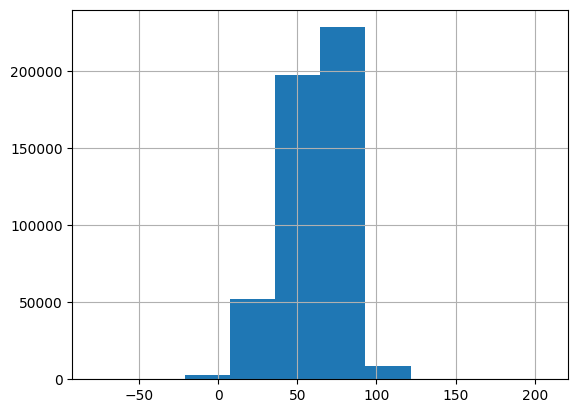

In [59]:
data_w_c['Temperature(F)'].hist()

<Axes: >

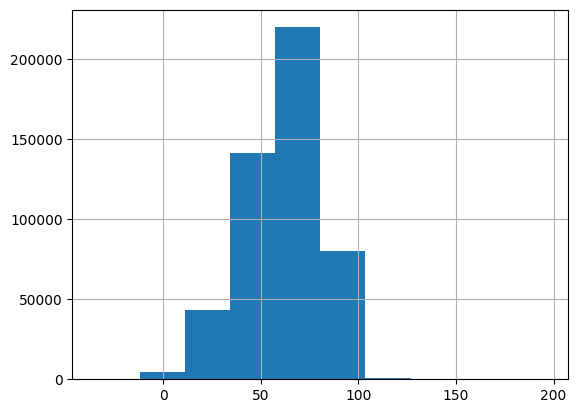

In [60]:
data_w_c['Temperature(F)'][(data_w_c['Temperature(F)'] <= 200)&(data_w_c['Temperature(F)'] > -50)].hist()

<Axes: >

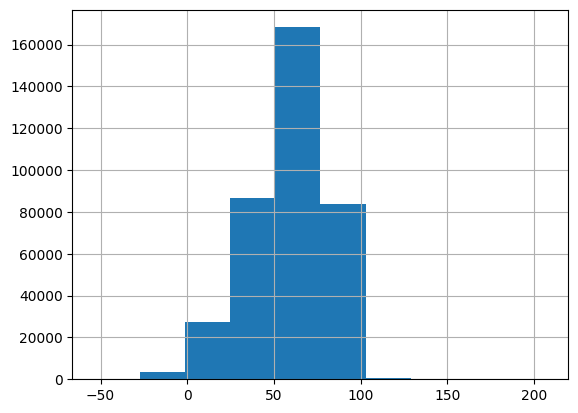

In [61]:
data_w_c['Wind_Chill(F)'].hist()

<Axes: >

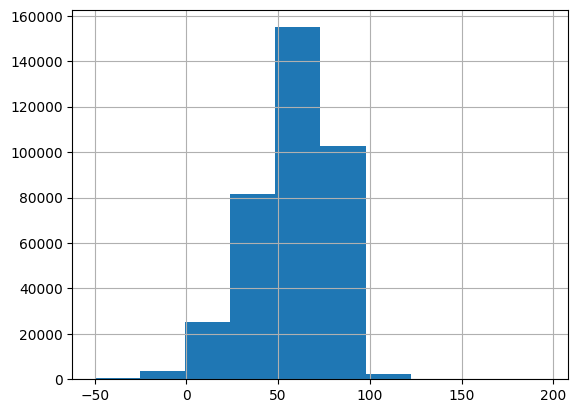

In [62]:
data_w_c['Wind_Chill(F)'][(data_w_c['Wind_Chill(F)'] <= 200)&(data_w_c['Wind_Chill(F)'] > -50)].hist()

<Axes: >

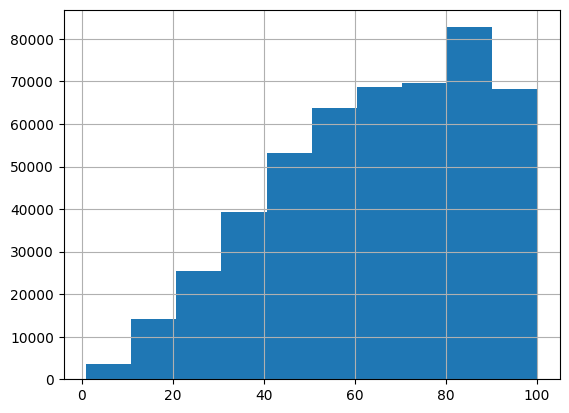

In [63]:
data_w_c['Humidity(%)'].hist()

<Axes: >

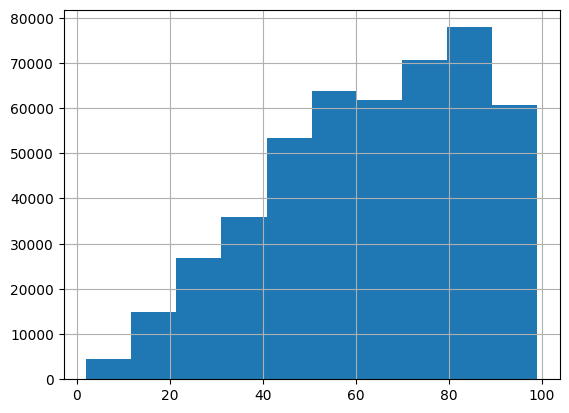

In [64]:
data_w_c['Humidity(%)'][(data_w_c['Humidity(%)'] !=1)&(data_w_c['Humidity(%)'] != 100)].hist()

<Axes: >

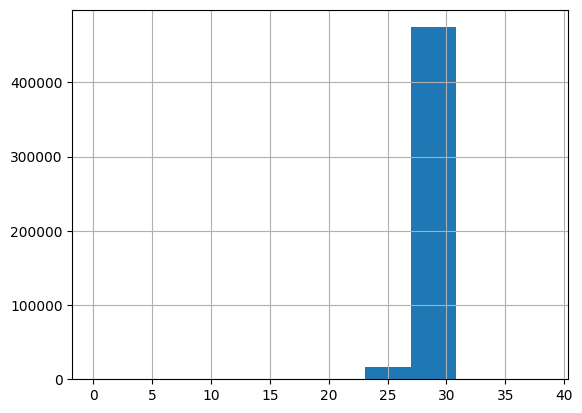

In [65]:
data_w_c['Pressure(in)'].hist()

<Axes: >

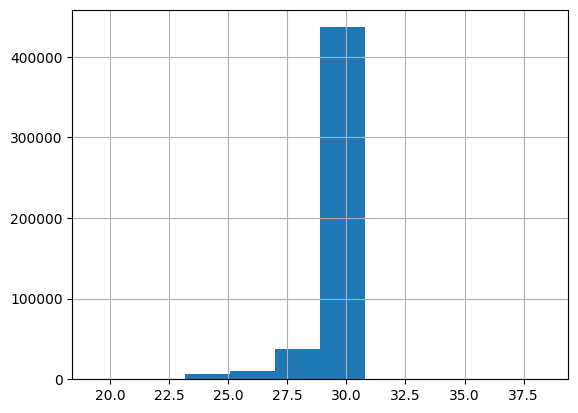

In [66]:
data_w_c['Pressure(in)'][(data_w_c['Pressure(in)'] > 3)].hist()

<Axes: >

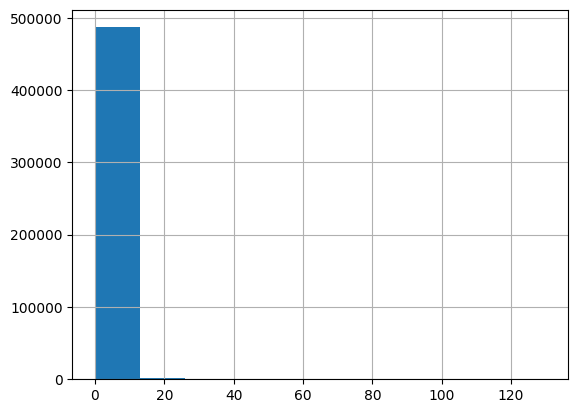

In [67]:
data_w_c['Visibility(mi)'].hist()

<Axes: >

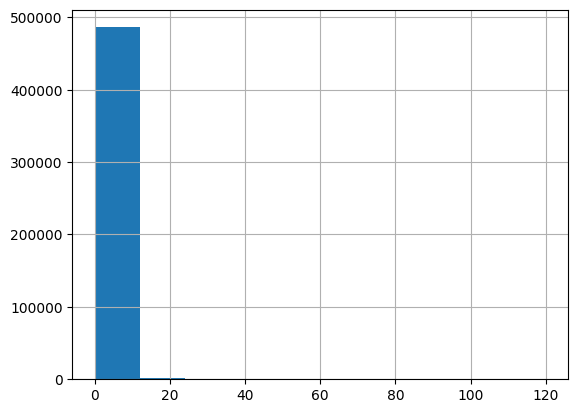

In [68]:
data_w_c['Visibility(mi)'][(data_w_c['Visibility(mi)'] != 0) & (data_w_c['Visibility(mi)'] != 130)].hist()

In [69]:
((data_w_c['Visibility(mi)'] == 0) | (data_w_c['Visibility(mi)'] == 130)).value_counts()

Visibility(mi)
False    499481
True        519
Name: count, dtype: int64

<Axes: >

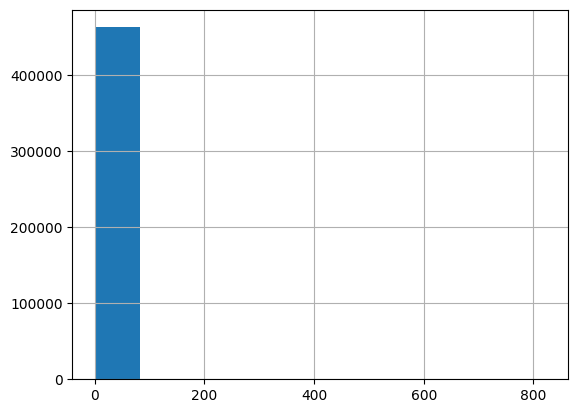

In [70]:
data_w_c['Wind_Speed(mph)'].hist()

<Axes: >

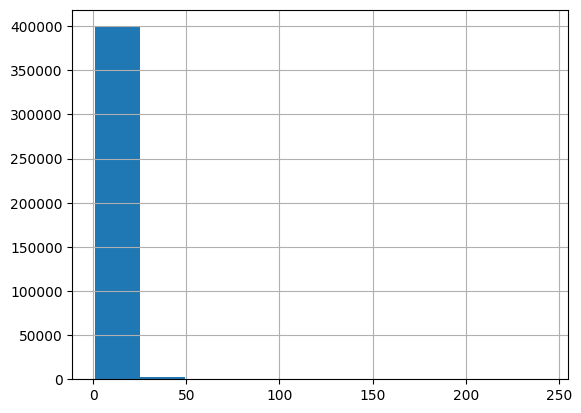

In [71]:
data_w_c['Wind_Speed(mph)'][(data_w_c['Wind_Speed(mph)'] != 0) & (data_w_c['Wind_Speed(mph)'] < 300)].hist()

We set the 300 mph bound because it is the aproximately point of the wind's speed in a hurricane.

Now that we have seen some missing values in our data, we will set no NA the values seen here in order to impute a prediction using the KNN algorithm.

In [72]:
data_w_c['Temperature(F)'][(data_w_c['Temperature(F)'] >= 200)|(data_w_c['Temperature(F)'] <= -50)] = np.nan
data_w_c['Wind_Chill(F)'][(data_w_c['Wind_Chill(F)'] >= 200)|(data_w_c['Wind_Chill(F)'] <= -50)] = np.nan
data_w_c['Humidity(%)'][(data_w_c['Humidity(%)'] == 1)|(data_w_c['Humidity(%)'] == 100)] = np.nan
data_w_c['Pressure(in)'][(data_w_c['Pressure(in)'] < 3)] = np.nan
data_w_c['Visibility(mi)'][(data_w_c['Visibility(mi)'] == 0)|(data_w_c['Visibility(mi)'] == 130)] = np.nan
data_w_c['Wind_Speed(mph)'][(data_w_c['Wind_Speed(mph)'] == 0)|(data_w_c['Wind_Speed(mph)'] >= 300)] = np.nan

Let's see the difference in the description table of the numerical variables of the dataset.

In [73]:
data_w_c.describe(include=['int', 'float'])

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,500000.000000,500000.000000,279623.000000,279623.000000,500000.000000,489532.000000,370975.000000,470461.000000,491070.000000,488190.000000,400753.000000,357384.000000,5.000000e+05
mean,36.206421,-94.736583,36.273192,-95.776553,0.564317,61.646242,58.230692,63.459133,29.536735,9.100939,8.872648,0.008289,2.538400e+04
std,5.071411,17.405761,5.265333,18.120211,1.774872,18.997991,22.346097,22.161575,1.007082,2.687707,4.673234,0.101865,7.922189e+05
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,-35.000000,-49.800000,2.000000,19.360000,0.060000,1.000000,0.000000,-8.463100e+04
25%,33.416823,-117.233047,33.474773,-117.778324,0.000000,49.000000,43.000000,47.000000,29.370000,10.000000,5.800000,0.000000,1.912000e+03
50%,35.832147,-87.794365,36.192669,-88.039013,0.029000,64.000000,62.000000,66.000000,29.860000,10.000000,8.000000,0.000000,4.500000e+03
75%,40.082443,-80.359601,40.181341,-80.252449,0.465000,76.000000,75.000000,82.000000,30.030000,10.000000,12.000000,0.000000,7.519000e+03
max,48.999569,-67.484130,48.998901,-67.484130,193.479996,196.000000,196.000000,99.000000,38.440000,120.000000,243.000000,10.130000,1.340115e+08


Now we have set no NAN all those values that we have considered to be something strange, we will impute these values using the KNN algorithm.

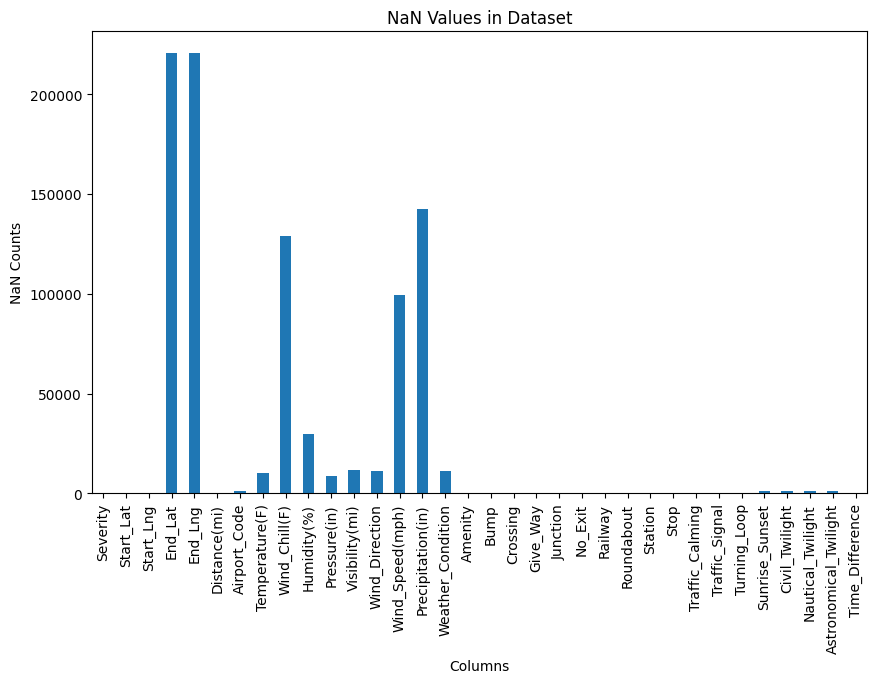

In [74]:
# nan histogram
nan_counts = data_w_c.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Columns')
plt.ylabel('NaN Counts')
plt.title('NaN Values in Dataset')
plt.show()

In [75]:
columns_with_nan = ['End_Lat', 'End_Lng', 'Airport_Code', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
subset_data_w_c = data_w_c.drop(columns=columns_with_nan)

In [76]:
subset_data_w_c.shape

(500000, 18)

In [77]:
data_w_c.shape

(500000, 34)

In [78]:
rows_not_missing = data_w_c['End_Lat'].notna() & data_w_c['End_Lng'].notna() & data_w_c['Airport_Code'].notna() & data_w_c['Temperature(F)'].notna() & data_w_c['Wind_Chill(F)'].notna() & data_w_c['Humidity(%)'].notna() & data_w_c['Pressure(in)'].notna() & data_w_c['Visibility(mi)'].notna() & data_w_c['Wind_Direction'].notna() & data_w_c['Wind_Speed(mph)'].notna() & data_w_c['Precipitation(in)'].notna() & data_w_c['Weather_Condition'].notna() & data_w_c['Sunrise_Sunset'].notna() & data_w_c['Civil_Twilight'].notna() & data_w_c['Nautical_Twilight'].notna() & data_w_c['Astronomical_Twilight'].notna()
data_w_c_without_missing = subset_data_w_c[rows_not_missing]
data_w_c_without_missing.shape

(185667, 18)

In [79]:
#Seguir lo que se dice en el notebook 1 pre-processing
knn1 = KNeighborsRegressor(n_neighbors=1)
knn2 = KNeighborsClassifier(n_neighbors=1)

for column in columns_with_nan:
    
    rows_column_missing = subset_data_w_c[data_w_c[column].isna()]

    if data_w_c[column].dtype == 'float' or data_w_c[column].dtype == 'int':
        knn = knn1
    elif data_w_c[column].dtype == 'object':
        knn = knn2

    knn.fit(data_w_c_without_missing, data_w_c[column][rows_not_missing])
    imputed_values = knn.predict(rows_column_missing)

    data_w_c[column][data_w_c[column].isna()] = imputed_values

data_w_c.isna().sum()  

Severity                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
Airport_Code             0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
Time_Difference          0
dtype: int64

In [81]:
data_without_nan = data_w_c
data_without_nan.describe(include='all')

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Airport_Code,Temperature(F),Wind_Chill(F),Humidity(%),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Time_Difference
count,500000.0,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000,500000.000000,500000.000000,500000.000000,...,500000,500000,500000,500000,500000,500000,500000,500000,500000,5.000000e+05
unique,4.0,NaN,NaN,NaN,NaN,NaN,1878,NaN,NaN,NaN,...,2,2,2,2,1,2,2,2,2,NaN
top,2.0,NaN,NaN,NaN,NaN,NaN,KCQT,NaN,NaN,NaN,...,False,False,False,False,False,Day,Day,Day,Day,NaN
freq,398142.0,NaN,NaN,NaN,NaN,NaN,7757,NaN,NaN,NaN,...,487002,485937,499534,425965,500000,345988,369348,394016,413427,NaN
mean,NaN,36.206421,-94.736583,36.155233,-94.701663,0.564317,NaN,61.678244,59.576280,63.318512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.538400e+04
std,NaN,5.071411,17.405761,5.047806,17.438105,1.774872,NaN,19.002249,22.216498,22.172555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.922189e+05
min,NaN,24.562117,-124.497420,24.570110,-124.497419,0.000000,NaN,-35.000000,-49.800000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.463100e+04
25%,NaN,33.416823,-117.233047,33.414660,-117.292162,0.000000,NaN,49.000000,44.000000,47.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.912000e+03
50%,NaN,35.832147,-87.794365,35.757350,-87.751530,0.029000,NaN,64.000000,64.000000,65.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.500000e+03
75%,NaN,40.082443,-80.359601,40.054649,-80.366935,0.465000,NaN,76.000000,76.000000,82.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.519000e+03


Our data has no Nan's, those who where have been imputated, now let's focus on the outliers.

FINDING OUTLIERS

It is important to identify these values, in order to take them into account when fitting models. Some of these models are sensitive to outliers. 

First let's see the variable Distance(mi), this has a clear outlier, it's max.

array([<Axes: title={'center': 'Distance(mi)'}>], dtype=object)

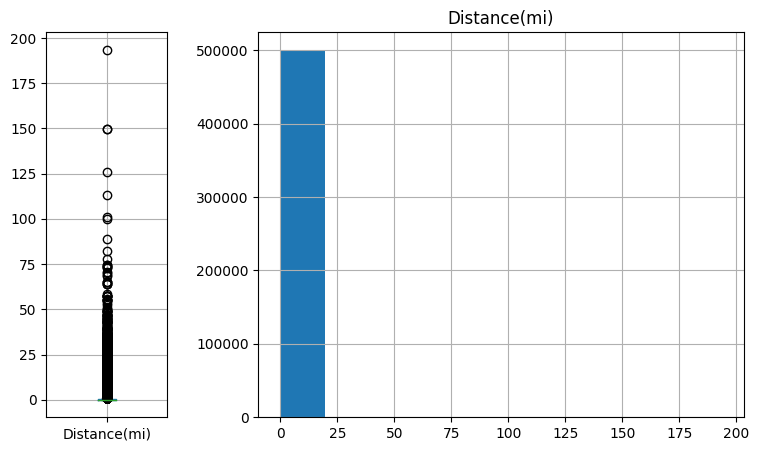

In [82]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan.boxplot(column='Distance(mi)',ax=axes[0])
data_without_nan.hist(column='Distance(mi)',ax=axes[1])

There are obviously a lot of values that do not represent the correct distribution of our variable.

Let's use the IQR to improve this. Later we will use the LocalOutlierFactor and compare the results, we will choose the better one.

array([<Axes: title={'center': 'Distance(mi)'}>], dtype=object)

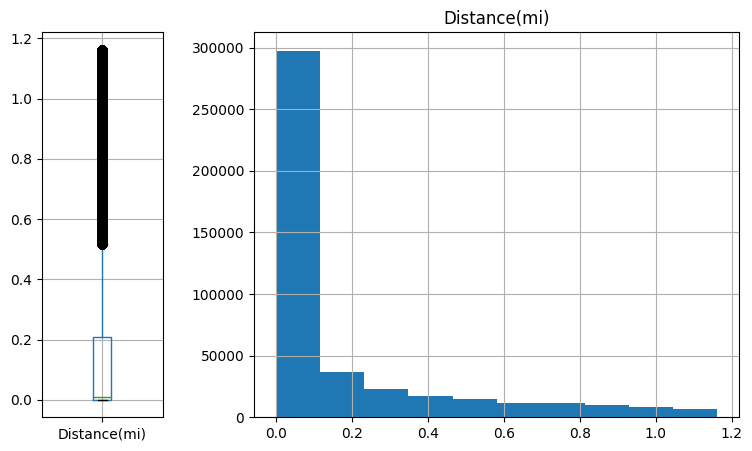

In [86]:
Q1 = data_without_nan['Distance(mi)'].quantile(0.25)
Q3 = data_without_nan['Distance(mi)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan['Distance(mi)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan['Distance(mi)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan[~(small_out | big_out)].boxplot(column='Distance(mi)',ax=axes[0])
data_without_nan[~(small_out | big_out)].hist(column='Distance(mi)',ax=axes[1])

Let's do it with the LocalOutlierFactor. With this algorithm we have seen that the results do not improve and it is very slow, so we will implement the IQR strategy in order to avoid outliers.

In [94]:
data_without_nan[~(small_out | big_out)].describe(include=['int', 'float']) 

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,437643.000000,437643.000000,437643.000000,437643.000000,437643.000000,437643.000000,437643.000000,437643.000000,437643.000000,437643.000000,437643.000000,437643.000000,4.376430e+05
mean,36.047915,-94.836808,35.993751,-94.797782,0.163273,62.093144,60.087911,63.294420,29.571005,9.136144,8.780152,0.007960,2.021591e+04
std,5.052891,17.360588,5.024288,17.396812,0.276345,18.715122,21.888241,22.112501,0.950213,2.659428,4.617648,0.104176,7.028608e+05
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,-35.000000,-49.800000,2.000000,19.520000,0.060000,1.000000,0.000000,-8.463100e+04
25%,33.194208,-117.251447,33.127125,-117.308484,0.000000,50.000000,45.000000,47.000000,29.400000,10.000000,5.800000,0.000000,1.832000e+03
50%,35.572556,-87.891250,35.387522,-87.861524,0.010000,64.000000,64.000000,65.000000,29.870000,10.000000,8.000000,0.000000,3.852000e+03
75%,39.956558,-80.416450,39.902939,-80.416521,0.207000,76.000000,77.000000,82.000000,30.040000,10.000000,11.500000,0.000000,7.265000e+03
max,48.999569,-67.484130,48.998901,-67.484130,1.162000,196.000000,196.000000,99.000000,38.440000,120.000000,243.000000,10.130000,1.340115e+08


In [95]:
data_without_nan_out1 = data_without_nan[~(small_out | big_out)]

Visibility:

array([<Axes: title={'center': 'Visibility(mi)'}>], dtype=object)

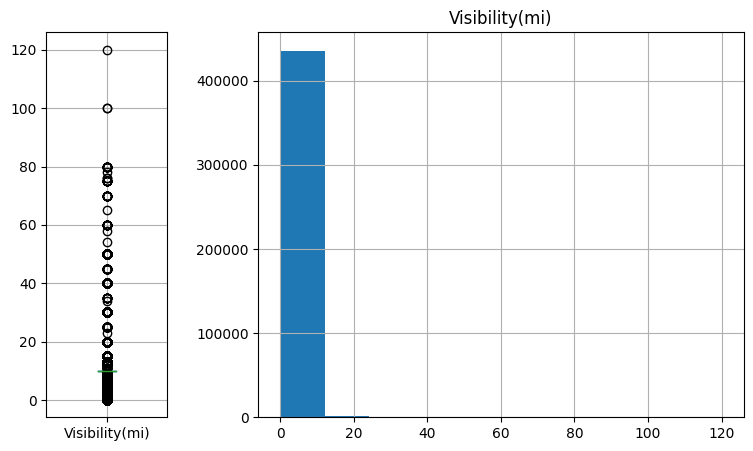

In [96]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out1.boxplot(column='Visibility(mi)',ax=axes[0])
data_without_nan_out1.hist(column='Visibility(mi)',ax=axes[1])

array([<Axes: title={'center': 'Visibility(mi)'}>], dtype=object)

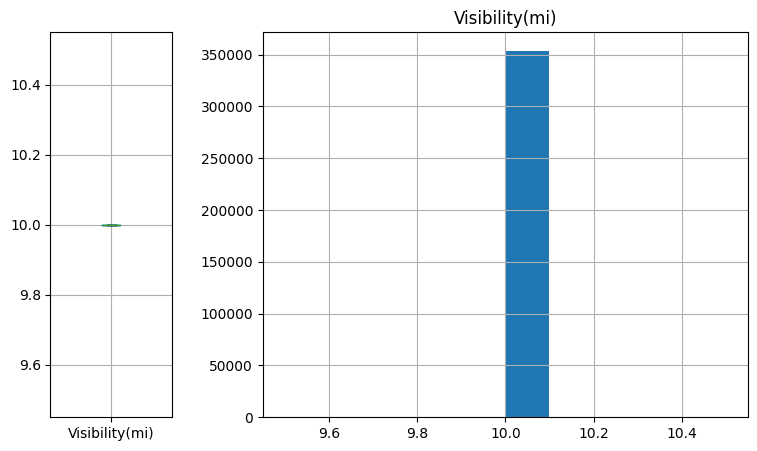

In [97]:
Q1 = data_without_nan_out1['Visibility(mi)'].quantile(0.25)
Q3 = data_without_nan_out1['Visibility(mi)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out1['Visibility(mi)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out1['Visibility(mi)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out1[~(small_out | big_out)].boxplot(column='Visibility(mi)',ax=axes[0])
data_without_nan_out1[~(small_out | big_out)].hist(column='Visibility(mi)',ax=axes[1])

All data from Visibility is concentrated around 10 mi.

In [98]:
data_without_nan_out1[~(small_out | big_out)].describe(include=['int', 'float']) 

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,353780.000000,353780.000000,353780.000000,353780.000000,353780.000000,353780.000000,353780.000000,353780.000000,353780.000000,353780.0,353780.000000,353780.000000,3.537800e+05
mean,35.843553,-94.595547,35.792062,-94.560237,0.162274,63.897871,61.792746,59.701642,29.576995,10.0,8.811790,0.003963,2.021236e+04
std,5.099621,17.302870,5.070820,17.342842,0.274003,18.328921,21.303377,21.153140,0.957502,0.0,4.540791,0.096985,7.133573e+05
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,-35.000000,-49.100000,2.000000,19.520000,10.0,1.000000,0.000000,-8.463100e+04
25%,32.900307,-117.145336,32.887814,-117.208757,0.000000,52.000000,50.000000,45.000000,29.420000,10.0,5.800000,0.000000,1.835000e+03
50%,35.350493,-87.558289,35.258380,-87.464409,0.010000,66.000000,66.000000,61.000000,29.880000,10.0,8.000000,0.000000,3.976000e+03
75%,39.798429,-80.380921,39.753500,-80.382443,0.204000,78.000000,78.000000,77.000000,30.040000,10.0,12.000000,0.000000,7.289000e+03
max,48.991585,-67.484130,48.998901,-67.484130,1.162000,196.000000,196.000000,99.000000,38.440000,10.0,243.000000,10.090000,1.340115e+08


In [100]:
data_without_nan_out2 = data_without_nan_out1[~(small_out | big_out)]

Temperature:

array([<Axes: title={'center': 'Temperature(F)'}>], dtype=object)

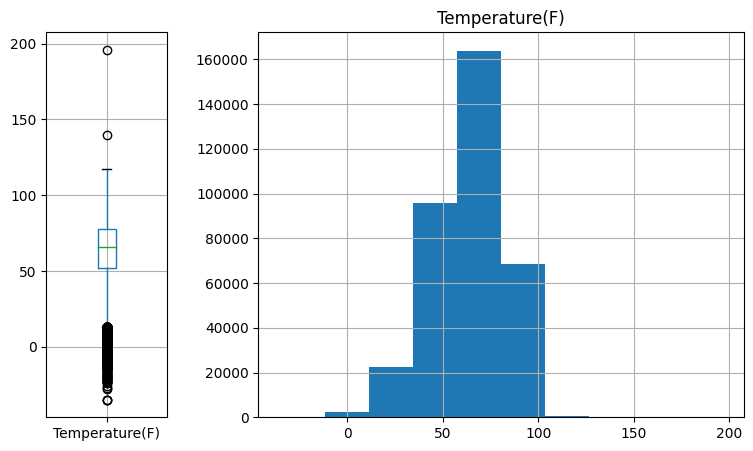

In [101]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out2.boxplot(column='Temperature(F)',ax=axes[0])
data_without_nan_out2.hist(column='Temperature(F)',ax=axes[1])

It seems well distributed. However, it seems there are some outliers. We will do the same for Wind_Chill since from the describe of the dataset, it is almost equally distributed as temperature.

array([<Axes: title={'center': 'Temperature(F)'}>], dtype=object)

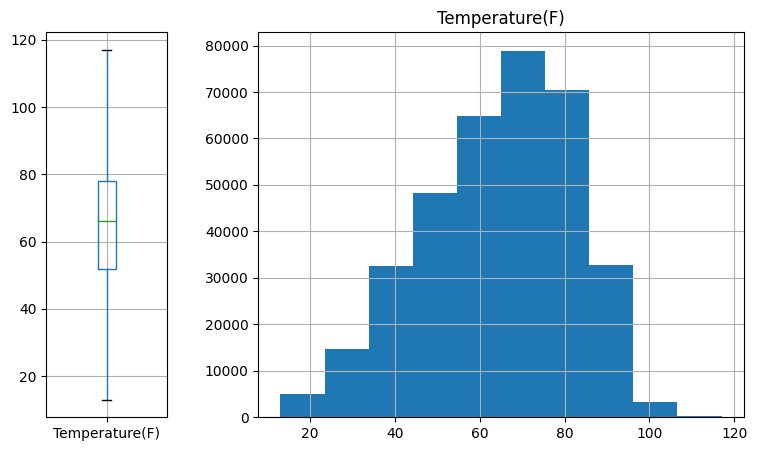

In [102]:
Q1 = data_without_nan_out2['Temperature(F)'].quantile(0.25)
Q3 = data_without_nan_out2['Temperature(F)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out2['Temperature(F)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out2['Temperature(F)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out2[~(small_out | big_out)].boxplot(column='Temperature(F)',ax=axes[0])
data_without_nan_out2[~(small_out | big_out)].hist(column='Temperature(F)',ax=axes[1])

It is better now.

In [103]:
data_without_nan_out2[~(small_out | big_out)].describe(include=['int', 'float']) 

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,351112.000000,351112.000000,351112.000000,351112.000000,351112.000000,351112.00000,351112.000000,351112.000000,351112.000000,351112.0,351112.000000,351112.000000,3.511120e+05
mean,35.788766,-94.626468,35.738243,-94.591199,0.161740,64.35381,62.294437,59.631653,29.578016,10.0,8.806516,0.003973,2.031680e+04
std,5.074986,17.346642,5.046621,17.386710,0.273511,17.61695,20.521192,21.191573,0.952290,0.0,4.538051,0.097339,7.160602e+05
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,13.00000,-48.500000,2.000000,19.520000,10.0,1.000000,0.000000,-8.463100e+04
25%,32.881428,-117.162781,32.869506,-117.243550,0.000000,52.00000,50.000000,44.000000,29.420000,10.0,5.800000,0.000000,1.835000e+03
50%,35.290653,-87.323295,35.232132,-87.278392,0.010000,66.00000,66.000000,61.000000,29.880000,10.0,8.000000,0.000000,3.972500e+03
75%,39.752371,-80.375011,39.684887,-80.382255,0.203000,78.00000,78.000000,77.000000,30.040000,10.0,12.000000,0.000000,7.290000e+03
max,48.991585,-67.484130,48.998901,-67.484130,1.162000,117.00000,115.000000,99.000000,38.440000,10.0,243.000000,10.090000,1.340115e+08


In [104]:
data_without_nan_out3 = data_without_nan_out2[~(small_out | big_out)]

Wind_Chill:

array([<Axes: title={'center': 'Wind_Chill(F)'}>], dtype=object)

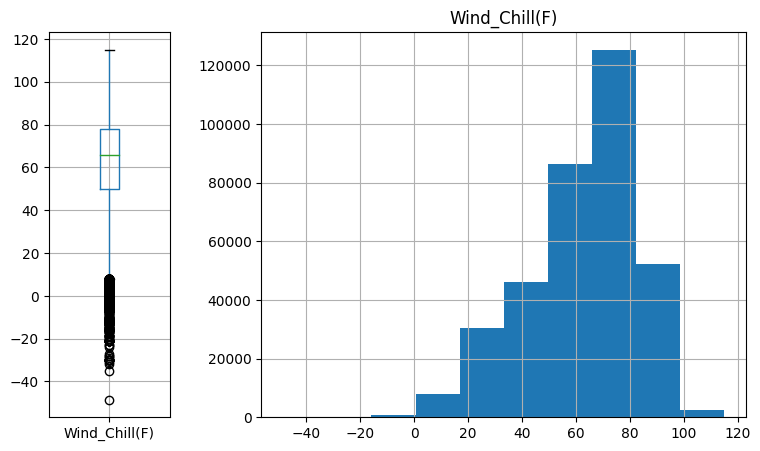

In [106]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out3.boxplot(column='Wind_Chill(F)',ax=axes[0])
data_without_nan_out3.hist(column='Wind_Chill(F)',ax=axes[1])

array([<Axes: title={'center': 'Wind_Chill(F)'}>], dtype=object)

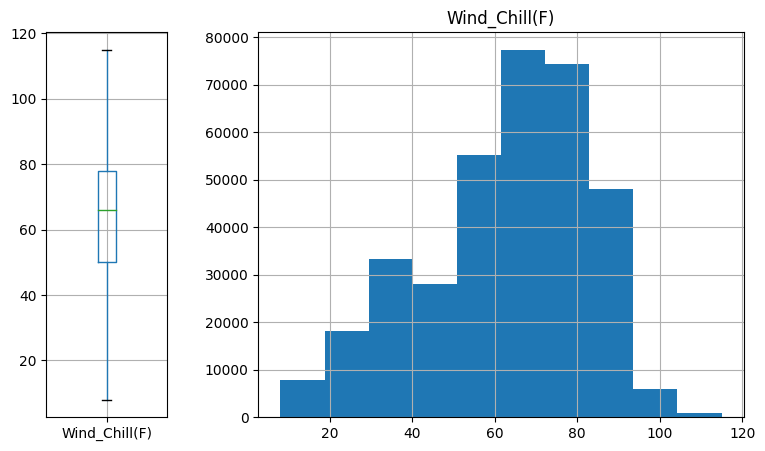

In [107]:
Q1 = data_without_nan_out3['Wind_Chill(F)'].quantile(0.25)
Q3 = data_without_nan_out3['Wind_Chill(F)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out3['Wind_Chill(F)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out3['Wind_Chill(F)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out3[~(small_out | big_out)].boxplot(column='Wind_Chill(F)',ax=axes[0])
data_without_nan_out3[~(small_out | big_out)].hist(column='Wind_Chill(F)',ax=axes[1])

The variable is better distributed now.

In [108]:
data_without_nan_out3[~(small_out | big_out)].describe(include=['int', 'float']) 

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,348563.000000,348563.000000,348563.000000,348563.000000,348563.000000,348563.000000,348563.000000,348563.000000,348563.000000,348563.0,348563.000000,348563.000000,3.485630e+05
mean,35.747003,-94.669169,35.696293,-94.634163,0.161263,64.559525,62.734742,59.619707,29.577832,10.0,8.783763,0.003954,2.039811e+04
std,5.063203,17.380489,5.033927,17.420847,0.273159,17.375847,19.930993,21.217177,0.949057,0.0,4.509579,0.096211,7.186723e+05
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,13.000000,8.000000,2.000000,19.520000,10.0,1.000000,0.000000,-8.463100e+04
25%,32.865604,-117.189210,32.851225,-117.266761,0.000000,52.000000,50.000000,44.000000,29.420000,10.0,5.800000,0.000000,1.835000e+03
50%,35.254768,-87.290512,35.209850,-87.240175,0.010000,66.000000,66.000000,61.000000,29.880000,10.0,8.000000,0.000000,3.965000e+03
75%,39.703856,-80.373314,39.587565,-80.382156,0.202000,78.000000,78.000000,77.000000,30.040000,10.0,11.500000,0.000000,7.284000e+03
max,48.991585,-67.484130,48.998901,-67.484130,1.162000,117.000000,115.000000,99.000000,38.440000,10.0,243.000000,10.090000,1.340115e+08


In [110]:
data_without_nan_out4 = data_without_nan_out3[~(small_out | big_out)]

Humidity:

array([<Axes: title={'center': 'Humidity(%)'}>], dtype=object)

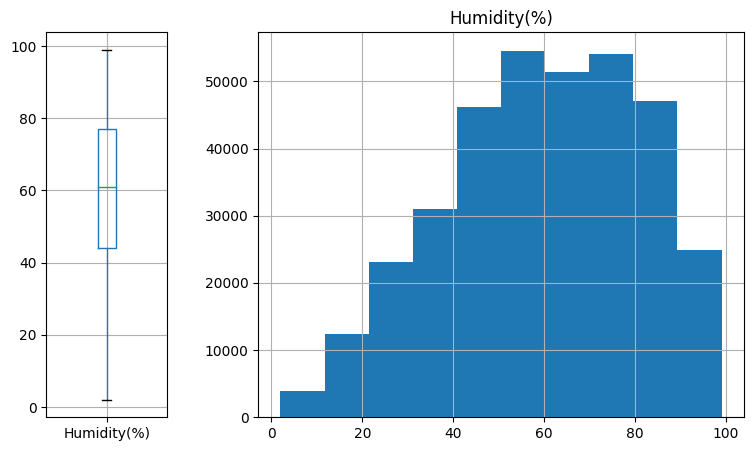

In [111]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out4.boxplot(column='Humidity(%)',ax=axes[0])
data_without_nan_out4.hist(column='Humidity(%)',ax=axes[1])

Humidity is well distributed.

Wind_Speed:

array([<Axes: title={'center': 'Wind_Speed(mph)'}>], dtype=object)

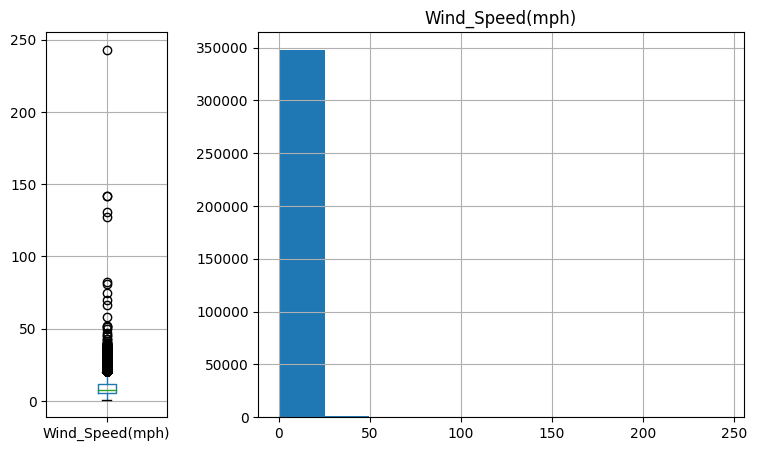

In [113]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out4.boxplot(column='Wind_Speed(mph)',ax=axes[0])
data_without_nan_out4.hist(column='Wind_Speed(mph)',ax=axes[1])

array([<Axes: title={'center': 'Wind_Speed(mph)'}>], dtype=object)

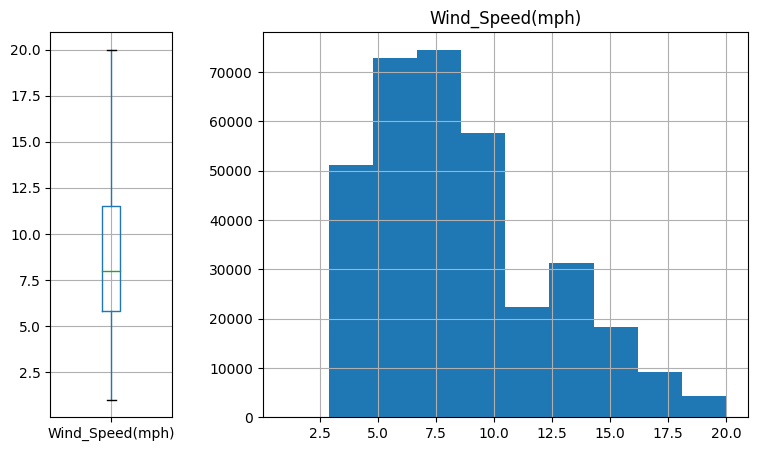

In [114]:
Q1 = data_without_nan_out4['Wind_Speed(mph)'].quantile(0.25)
Q3 = data_without_nan_out4['Wind_Speed(mph)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out4['Wind_Speed(mph)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out4['Wind_Speed(mph)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out4[~(small_out | big_out)].boxplot(column='Wind_Speed(mph)',ax=axes[0])
data_without_nan_out4[~(small_out | big_out)].hist(column='Wind_Speed(mph)',ax=axes[1])

In [115]:
data_without_nan_out4[~(small_out | big_out)].describe(include=['int', 'float'])

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,341388.000000,341388.000000,341388.000000,341388.000000,341388.000000,341388.000000,341388.000000,341388.000000,341388.000000,341388.0,341388.000000,341388.000000,3.413880e+05
mean,35.719974,-94.661841,35.670853,-94.627286,0.160986,64.644805,62.855184,59.762045,29.584327,10.0,8.474261,0.003960,2.039278e+04
std,5.057118,17.384842,5.026357,17.425664,0.272984,17.368739,19.867208,21.188465,0.939021,0.0,3.946547,0.097063,7.205695e+05
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,13.000000,8.000000,2.000000,19.520000,10.0,1.000000,0.000000,-8.463100e+04
25%,32.858022,-117.197767,32.849320,-117.275835,0.000000,52.000000,51.000000,45.000000,29.430000,10.0,5.800000,0.000000,1.835000e+03
50%,35.226565,-87.213675,35.201180,-87.122675,0.010000,66.700000,66.000000,61.000000,29.880000,10.0,8.000000,0.000000,3.960000e+03
75%,39.655717,-80.376569,39.481921,-80.382356,0.201000,78.000000,78.000000,77.000000,30.040000,10.0,11.500000,0.000000,7.280000e+03
max,48.991585,-67.484130,48.998901,-67.484130,1.162000,117.000000,115.000000,99.000000,38.440000,10.0,20.000000,10.090000,1.340115e+08


In [117]:
data_without_nan_out5 = data_without_nan_out4[~(small_out | big_out)]

Precipitation:

array([<Axes: title={'center': 'Precipitation(in)'}>], dtype=object)

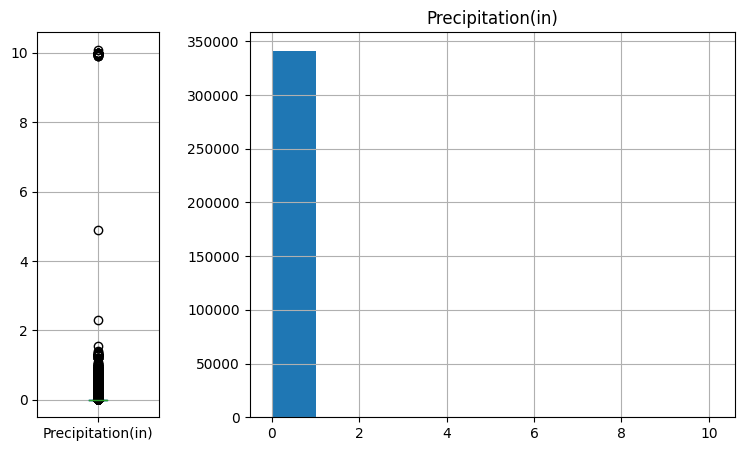

In [118]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out5.boxplot(column='Precipitation(in)',ax=axes[0])
data_without_nan_out5.hist(column='Precipitation(in)',ax=axes[1])

array([<Axes: title={'center': 'Precipitation(in)'}>], dtype=object)

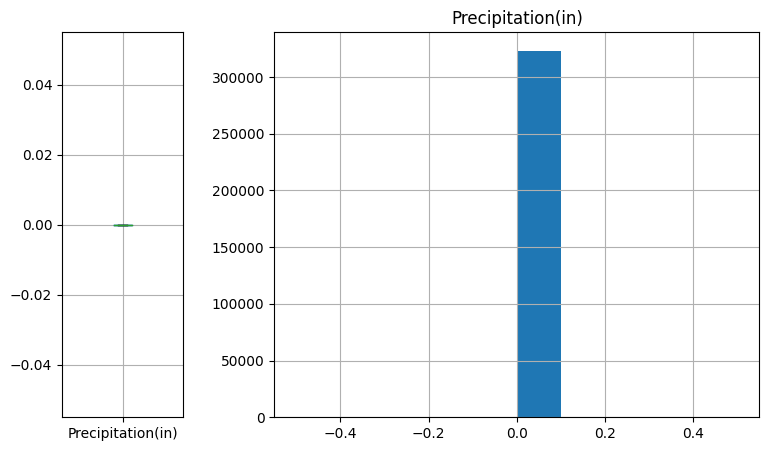

In [119]:
Q1 = data_without_nan_out5['Precipitation(in)'].quantile(0.25)
Q3 = data_without_nan_out5['Precipitation(in)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out5['Precipitation(in)'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out5['Precipitation(in)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out5[~(small_out | big_out)].boxplot(column='Precipitation(in)',ax=axes[0])
data_without_nan_out5[~(small_out | big_out)].hist(column='Precipitation(in)',ax=axes[1])

In [120]:
data_without_nan_out5[~(small_out | big_out)].describe(include=['int', 'float'])

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,323299.000000,323299.000000,323299.000000,323299.000000,323299.000000,323299.000000,323299.000000,323299.000000,323299.000000,323299.0,323299.000000,323299.0,3.232990e+05
mean,35.667459,-94.880059,35.619936,-94.848967,0.160391,64.750953,63.448494,59.178473,29.571029,10.0,8.465403,0.0,2.062750e+04
std,5.025355,17.431753,4.991893,17.473664,0.272824,17.387139,19.667645,21.041476,0.951384,0.0,3.940646,0.0,7.320824e+05
min,24.562117,-124.497420,24.570110,-124.497419,0.000000,13.000000,8.000000,2.000000,19.520000,10.0,1.000000,0.0,-8.463100e+04
25%,32.848440,-117.281331,32.843030,-117.347577,0.000000,53.000000,52.000000,44.000000,29.410000,10.0,5.800000,0.0,1.838000e+03
50%,35.200164,-87.598114,35.164999,-87.550006,0.010000,66.900000,67.000000,61.000000,29.870000,10.0,8.000000,0.0,3.977000e+03
75%,39.502493,-80.387305,39.308129,-80.392748,0.198000,78.000000,79.000000,76.000000,30.040000,10.0,10.400000,0.0,7.211000e+03
max,48.991585,-67.484130,48.998901,-67.484130,1.162000,117.000000,115.000000,99.000000,38.440000,10.0,20.000000,0.0,1.340115e+08


In [121]:
data_without_nan_out6 = data_without_nan_out5[~(small_out | big_out)]

Time_Difference:

array([<Axes: title={'center': 'Time_Difference'}>], dtype=object)

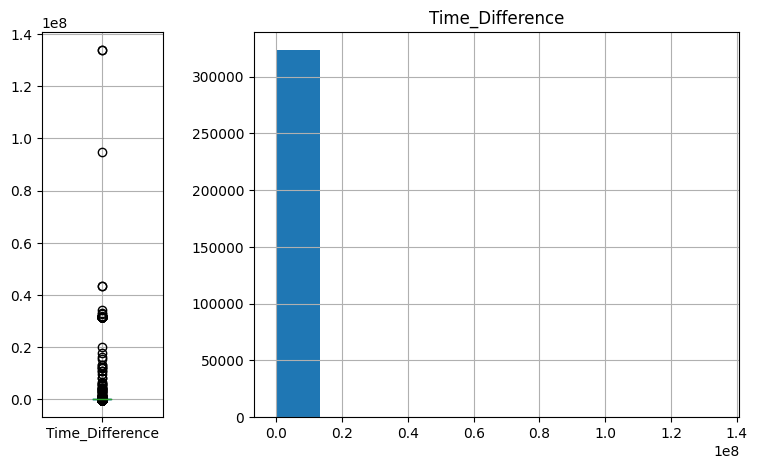

In [122]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out6.boxplot(column='Time_Difference',ax=axes[0])
data_without_nan_out6.hist(column='Time_Difference',ax=axes[1])

array([<Axes: title={'center': 'Time_Difference'}>], dtype=object)

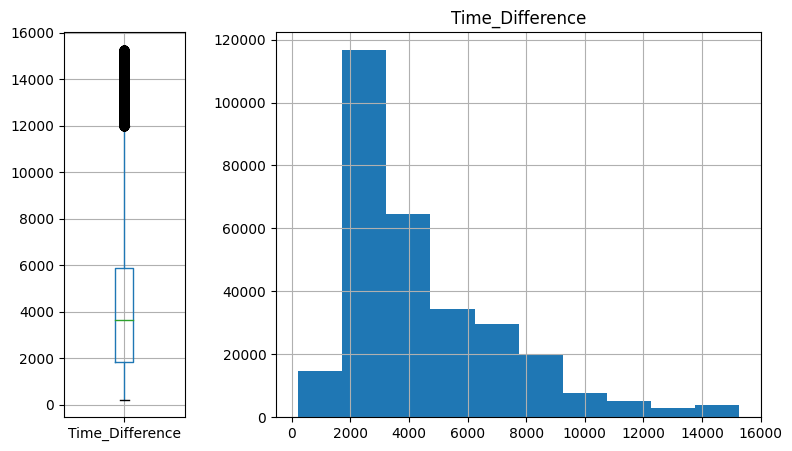

In [123]:
Q1 = data_without_nan_out6['Time_Difference'].quantile(0.25)
Q3 = data_without_nan_out6['Time_Difference'].quantile(0.75)
IQR = Q3 - Q1

small_out = data_without_nan_out6['Time_Difference'] < (Q1 - 1.5 * IQR)
big_out = data_without_nan_out6['Time_Difference'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out6[~(small_out | big_out)].boxplot(column='Time_Difference',ax=axes[0])
data_without_nan_out6[~(small_out | big_out)].hist(column='Time_Difference',ax=axes[1])

In [124]:
data_without_nan_out6[~(small_out | big_out)].describe(include=['int', 'float'])

,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Time_Difference
count,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.000000,299327.0,299327.000000,299327.0,299327.000000
mean,35.724773,-94.781265,35.674699,-94.749543,0.146347,64.716406,63.889803,59.126464,29.559269,10.0,8.445881,0.0,4418.941616
std,4.979161,17.396519,4.943341,17.440721,0.265089,17.430938,19.393081,21.063318,0.956906,0.0,3.931528,0.0,2860.134741
min,24.562117,-124.494330,24.570110,-124.495392,0.000000,13.000000,8.000000,2.000000,19.520000,10.0,1.000000,0.0,210.000000
25%,32.900779,-117.229658,32.893150,-117.305577,0.000000,53.000000,52.000000,44.000000,29.380000,10.0,5.800000,0.0,1826.000000
50%,35.220367,-87.336800,35.188631,-87.295737,0.000000,66.900000,67.000000,60.000000,29.860000,10.0,8.000000,0.0,3617.000000
75%,39.546116,-80.385739,39.341020,-80.392713,0.160000,78.100000,79.000000,76.000000,30.040000,10.0,10.400000,0.0,5891.000000
max,48.991585,-67.484130,48.998901,-67.484130,1.162000,117.000000,115.000000,99.000000,38.440000,10.0,20.000000,0.0,15270.000000


Every numerical feature has been treated, now let's analyze the categorical variables.

In [126]:
data_without_nan_out7 = data_without_nan_out6[~(small_out | big_out)]

In [127]:
data_without_nan_out7.describe(include=['O'])

,Severity,Airport_Code,Wind_Direction,Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
count,299327,299327,299327,299327,299327,299327,299327,299327,299327,299327,...,299327,299327,299327,299327,299327,299327,299327,299327,299327,299327
unique,4,1688,24,52,2,2,2,2,2,2,...,2,2,2,2,2,1,2,2,2,2
top,2,KRDU,CALM,Fair,False,False,False,False,False,False,...,False,False,False,False,False,False,Day,Day,Day,Day
freq,237922,5062,36024,125234,294953,299175,258821,297798,280784,298466,...,299320,290050,289653,299004,246772,299327,211456,224562,238824,250072


KeyError: "None of [Index(['Amenity'], dtype='object')] are in the [columns]"

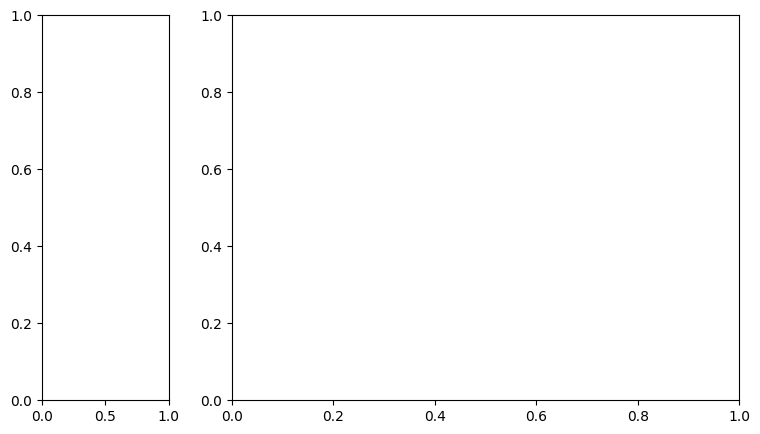

In [129]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data_without_nan_out7.boxplot(column='Amenity',ax=axes[0])
data_without_nan_out7.hist(column='Amenity',ax=axes[1])